In [139]:
# Import des bibliothèques nécessaires
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans


In [140]:
# Charger le fichier CSV
billets_df = pd.read_csv('billets.csv', delimiter=';')

Étape 1 : Créer un modèle de régression avec toutes les variables disponibles.

In [141]:
reg_multi = smf.ols('margin_low ~ is_genuine + diagonal + height_left + height_right + margin_up + length', data=billets_df).fit()


Étape 2 : Élimination régressive. Dans cette étape, nous allons éliminer progressivement les variables qui ne sont pas statistiquement significatives. La p-valeur est utilisée comme critère : une variable est considérée comme non significative si sa p-valeur est supérieure à 0,05.

In [142]:
variables = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']

while True:
    # Construction de la formule de régression
    formula = 'margin_low ~ ' + ' + '.join(variables)
    
    # Entraînement du modèle de régression
    reg_multi = smf.ols(formula, data=billets_df).fit()
    
    # Récupération des p-valeurs
    pvalues = reg_multi.pvalues.drop('Intercept')
    
    # Si toutes les p-valeurs sont inférieures à 0.05, on sort de la boucle
    if pvalues.max() < 0.05:
        break
    
    # Sinon, on élimine la variable avec la p-valeur la plus élevée
    remove = pvalues.idxmax()
    variables.remove(remove)


Étape 3 : À ce stade, nous avons un modèle avec seulement les variables significatives. Vous pouvez l'utiliser pour prédire margin_low pour les observations où cette valeur est manquante.

In [143]:
# Création d'un dataframe avec les variables du modèle final
model_var = billets_df[variables].copy()

# Prédiction de margin_low
margin_low_prev = reg_multi.predict(model_var)

# Remplacement des valeurs manquantes dans le DataFrame d'origine
billets_df['margin_low'].fillna(margin_low_prev, inplace=True)


In [144]:
# Vérifier la présence de valeurs manquantes dans le DataFrame
missing_values_check = billets_df.isnull().sum()

missing_values_check

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

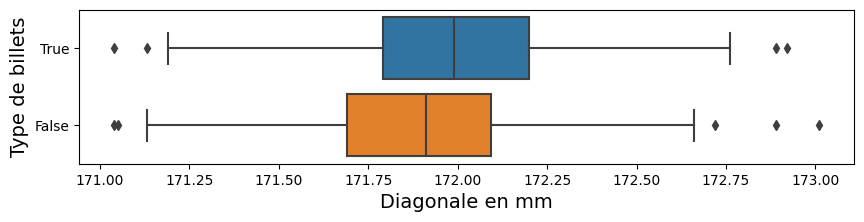

In [145]:
# Convertir les valeurs booléennes en chaînes de caractères pour faciliter l'utilisation avec Seaborn
str_genui_data = billets_df.copy()
str_genui_data['is_genuine'] = str_genui_data['is_genuine'].map({True: 'True', False: 'False'})

# 4.1 Diagonale
plt.figure(figsize=(10, 2))
sns.boxplot(x="diagonal", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Diagonale en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



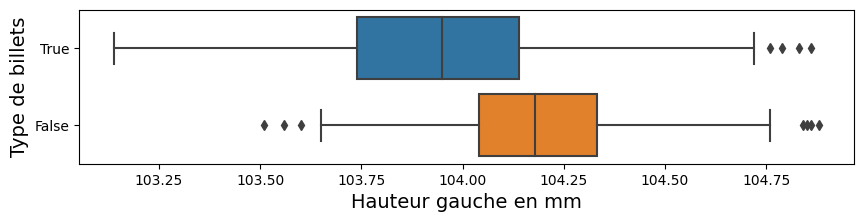

In [146]:
# 4.3 Hauteur gauche
plt.figure(figsize=(10, 2))
sns.boxplot(x="height_left", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Hauteur gauche en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



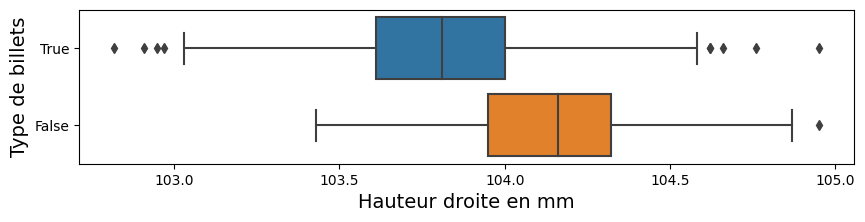

In [147]:
# 4.4 Hauteur droite
plt.figure(figsize=(10, 2))
sns.boxplot(x="height_right", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Hauteur droite en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



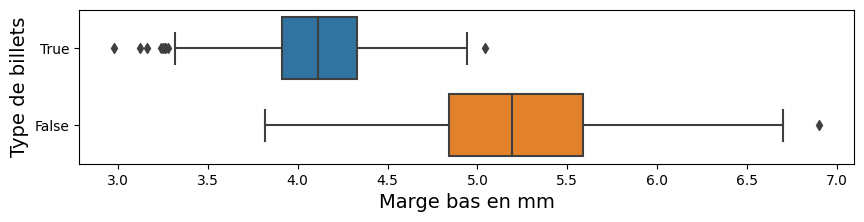

In [148]:
# 4.5 Marge du bas
plt.figure(figsize=(10, 2))
sns.boxplot(x="margin_low", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Marge bas en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



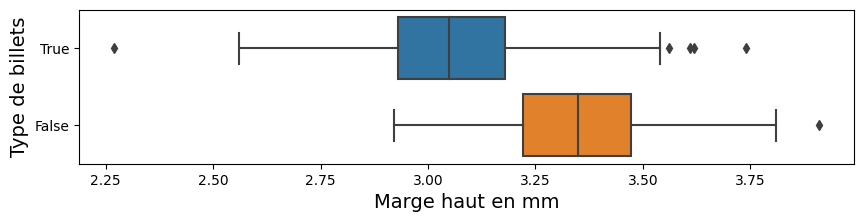

In [149]:
# 4.6 Marge haut
plt.figure(figsize=(10, 2))
sns.boxplot(x="margin_up", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Marge haut en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



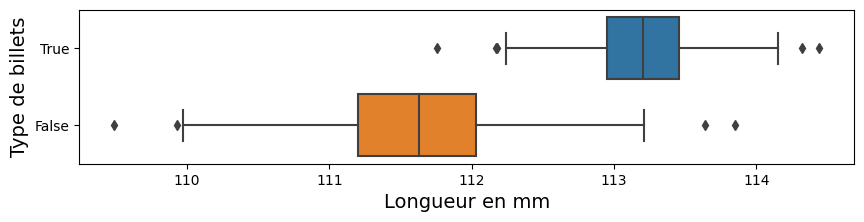

In [150]:
# 4.7 Longueur
plt.figure(figsize=(10, 2))
sns.boxplot(x="length", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Longueur en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()

## 5. Algorithmes de détection


### 5.1 Régression logistique

La régression logistique est une méthode statistique permettant de modéliser la probabilité d'appartenance d'une observation à une classe.

#### 5.1.1 Préparation des données

Nous allons d'abord convertir les valeurs de 'is_genuine' en nombres entiers pour faciliter l'entraînement.


In [151]:
int_genui_data = billets_df.copy()
int_genui_data['is_genuine'] = int_genui_data['is_genuine'].map({True: 0, False: 1})

# Séparation des variables indépendantes (X) et de la variable cible (y)
X = int_genui_data.drop(columns="is_genuine")
y = int_genui_data.is_genuine


#### 5.1.2 Partage de l'échantillon pour le test et l'entraînement

Nous allons diviser le jeu de données en deux : un ensemble d'entraînement et un ensemble de test.


In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")


Nous avons X_train de forme (1200, 6) et y_train de forme (1200,)
Nous avons X_test de forme (300, 6) et y_test de forme (300,)


#### 5.1.3 Entraînement du modèle

Nous allons maintenant entraîner un modèle de régression logistique sur nos données.


In [153]:
estimator = LogisticRegression(solver='liblinear')
estimator.fit(X_train, y_train)


LogisticRegression(solver='liblinear')

#### 5.1.4 Prédictions et probabilités

Après avoir entraîné le modèle, nous pouvons l'utiliser pour faire des prédictions sur l'ensemble de test. Nous pouvons également obtenir les probabilités d'appartenance à chaque classe pour chaque observation.


In [154]:
y_pred = estimator.predict(X_test)
y_prob = estimator.predict_proba(X_test).round(2)


#### 5.1.5 Évaluation du modèle

Enfin, évaluons la performance de notre modèle en calculant sa précision sur les ensembles d'entraînement et de test.


In [155]:
def score(estimator):
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)
    return tr_score, te_score

tr_score, te_score = score(estimator)
print(f"score train : {tr_score} score test : {te_score}")


score train : 0.9908 score test : 0.99


## 5.1.4 Test du modèle avec la régression logistique

Nous allons tester la qualité de notre modèle de régression logistique en utilisant une matrice de confusion.


In [156]:
def confusion(y_test, y_pred):
    """Affiche une matrice de confusion formatée"""
    mat = confusion_matrix(y_test, y_pred)
    mat_df = pd.DataFrame(mat)
    mat_df.columns = [f"pred_{i}" for i in mat_df.columns]
    mat_df.index = [f"test_{i}" for i in mat_df.index]
    return mat_df

confusion_mat = confusion(y_test, y_pred)
confusion_mat


,pred_0,pred_1
test_0,190,0
test_1,3,107


### Courbe ROC

La courbe ROC (Receiver Operating Characteristic) est un outil graphique utilisé en classification pour étudier les performances d'un modèle.


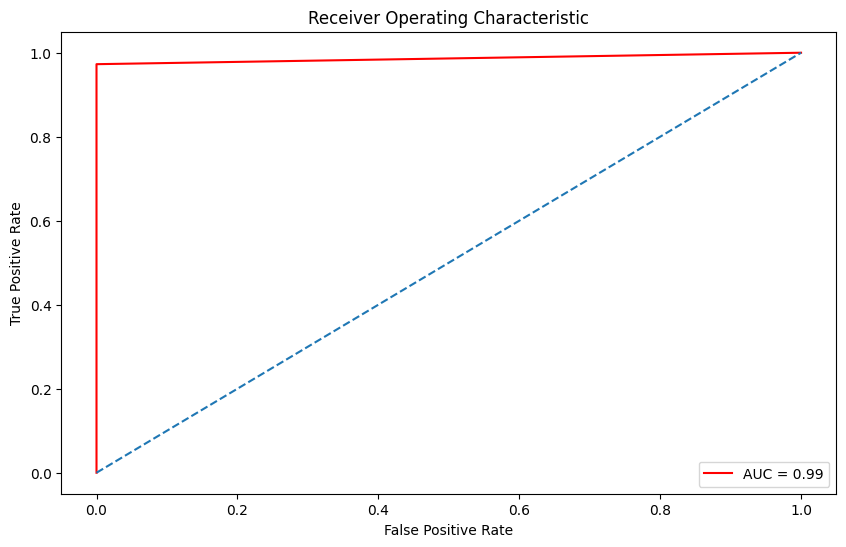

In [157]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate).round(2)

plt.figure(figsize=(10, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, color='red', label=f'AUC = {roc_auc}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 5.2 Détection avec K-means

Nous allons maintenant utiliser l'algorithme K-means pour classer les billets en vrais et faux et évaluer les performances de cet algorithme.


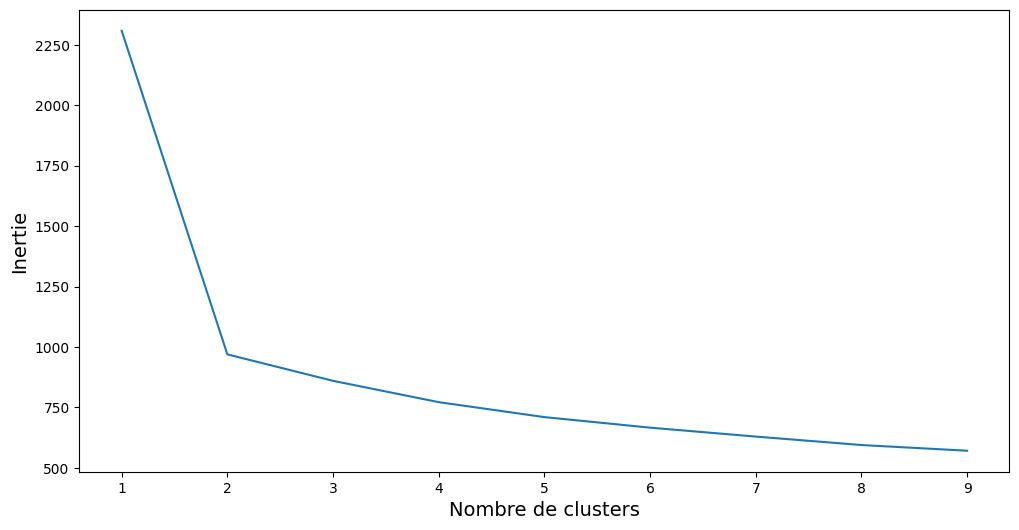

In [158]:
# Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
k_list = range(1, 10)

for i in k_list:
    kmeans = KMeans(n_clusters=i, n_init=10)

    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Affichage de l'inertie intraclasse en fonction du nombre de clusters
plt.figure(figsize=(12, 6))
plt.ylabel("Inertie", fontsize=14)
plt.xlabel("Nombre de clusters", fontsize=14)
plt.plot(k_list, inertia)
plt.show()


### Entraînement et test du modèle K-means


In [159]:
kmeans = KMeans(n_clusters=2,n_init=10)
kmeans.fit(X_train, y_train)
prediction = kmeans.predict(X_test)

# Calcul de la précision
correct = sum([1 for i in range(len(y_test)) if prediction[i] == y_test.iloc[i]])
accuracy_kmeans = correct / len(y_test)

# Affichage de la matrice de confusion pour K-means
kmeans_mat = confusion(y_test, prediction)
kmeans_mat, accuracy_kmeans


(        pred_0  pred_1
 test_0     190       0
 test_1       6     104,
 0.98)

## 5 Application du modèle sur les données de production

Nous allons appliquer le modèle de régression logistique que nous avons formé précédemment sur un nouvel ensemble de données pour déterminer l'authenticité des billets.


In [160]:
# Chargement des données
prod_data = pd.read_csv('billets_production.csv')
print(prod_data.shape)
prod_data.head()


(5, 7)


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


### Préparation des données

Nous allons supprimer la colonne 'id' car elle n'est pas nécessaire pour la prédiction.


In [161]:
prod_data = prod_data.drop(columns='id')
prod_data


,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.76,104.01,103.54,5.21,3.30,111.42
1,171.87,104.17,104.13,6.00,3.31,112.09
2,172.00,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.20
4,171.65,103.63,103.56,3.77,3.16,113.33


### Application du modèle de régression logistique

Nous allons utiliser notre modèle précédemment formé pour prédire si ces billets sont authentiques ou non.


In [162]:
prod_genui = estimator.predict(prod_data)
prod_genui


array([1, 1, 1, 0, 0], dtype=int64)

### Ajout des prédictions au dataframe original

Nous allons ajouter une colonne 'is_genuine' au dataframe pour indiquer si le billet est authentique selon notre modèle.


In [163]:
prod_data["is_genuine"] = prod_genui

# Convertir les prédictions en valeurs booléennes
prod_data.is_genuine = ~prod_data.is_genuine.astype('bool')

prod_data


,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,False
1,171.87,104.17,104.13,6.00,3.31,112.09,False
2,172.00,104.58,104.29,4.99,3.39,111.57,False
3,172.49,104.55,104.34,4.44,3.03,113.20,True
4,171.65,103.63,103.56,3.77,3.16,113.33,True
